In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme(color_codes=True)
from tqdm import tqdm
import os

In [4]:
%%time
data_dir = '/opt/ml/project/data'
dtype = {
    'userID': 'int16',
    'answerCode': 'int8',
    'KnowledgeTag': 'int16'
} 

train_df = pd.read_csv(os.path.join(data_dir, 'train_data.csv'), dtype=dtype, parse_dates=['Timestamp'])
test_df = pd.read_csv(os.path.join(data_dir, 'test_data.csv'), dtype=dtype, parse_dates=['Timestamp'])

cond = test_df['answerCode'] != -1
df = pd.concat([train_df, test_df[cond]])
df = df.sort_values(by=['userID', 'Timestamp']).reset_index(drop=True)

CPU times: user 4.61 s, sys: 504 ms, total: 5.11 s
Wall time: 5.11 s


In [3]:
def percentile(s):
    return np.sum(s) / len(s)

In [ ]:
plt.figure(figsize=(12,8))
elapsedTime_df = df[df.userID.shift(1) == df.userID]
elapsedTime = (elapsedTime_df.Timestamp.shift(-1) - elapsedTime_df.Timestamp).values / np.timedelta64(1, 's')
elapsedTime = elapsedTime[~np.isnan(elapsedTime)]
elapsedTime = elapsedTime[elapsedTime > 0]
sns.boxplot(data=elapsedTime, color='red')
plt.show()

## 1. 유저/문항/시험/태그별 분포도

##### 유저별 푼 문제 수 & 정답률 분포

In [7]:
stu_groupby = df.groupby('userID').agg({
    'assessmentItemID': 'count',
    'answerCode': percentile
})
stu_groupby.describe()

,assessmentItemID,answerCode
count,7442.000000,7442.000000
mean,339.418973,0.628749
std,321.465413,0.159608
min,9.000000,0.000000
25%,78.000000,0.526782
50%,232.500000,0.651923
75%,519.000000,0.750728
max,1860.000000,1.000000


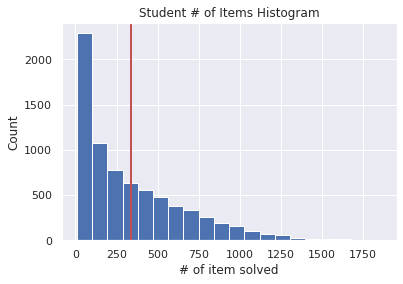

In [8]:
plt.title('Student # of Items Histogram')
plt.xlabel('# of item solved')
plt.ylabel('Count')
plt.hist(stu_groupby['assessmentItemID'], bins=20)
plt.axvline(stu_groupby['assessmentItemID'].mean(), color='r', linewidth=2)
plt.show()

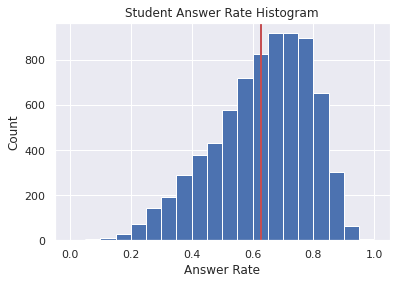

In [9]:
plt.title('Student Answer Rate Histogram')
plt.xlabel('Answer Rate')
plt.ylabel('Count')
plt.hist(stu_groupby['answerCode'], bins=20)
plt.axvline(stu_groupby['answerCode'].mean(), color='r', linewidth=2)
plt.show()

##### 문항별 정답률 분포

In [10]:
item_groupby = df.groupby('assessmentItemID').agg({
    'userID': 'count',
    'answerCode': percentile
})
item_groupby.describe()

,userID,answerCode
count,9454.000000,9454.000000
mean,267.183838,0.654468
std,79.648425,0.195183
min,46.000000,0.043333
25%,250.000000,0.504000
50%,250.000000,0.666667
75%,300.000000,0.820000
max,500.000000,0.996667


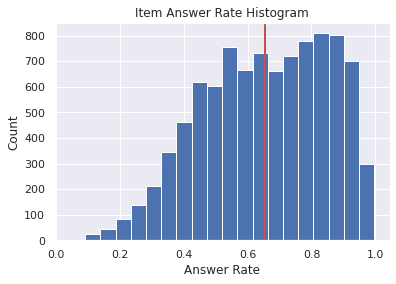

In [11]:
plt.title('Item Answer Rate Histogram')
plt.xlabel('Answer Rate')
plt.ylabel('Count')
plt.hist(item_groupby['answerCode'], bins=20)
plt.axvline(item_groupby['answerCode'].mean(), color='r', linewidth=2)
plt.show()

##### 시험별 정답률 분포

In [12]:
test_groupby = df.groupby('testId').agg({
    'assessmentItemID': 'count',
    'answerCode': percentile
})
test_groupby.describe()

,assessmentItemID,answerCode
count,1537.000000,1537.000000
mean,1643.432661,0.668194
std,592.144998,0.138739
min,200.000000,0.330625
25%,1499.000000,0.561781
50%,1500.000000,0.681490
75%,1794.000000,0.778731
max,4398.000000,0.956638


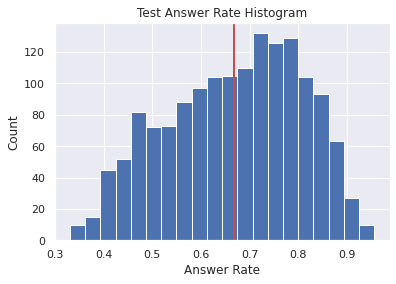

In [13]:
plt.title('Test Answer Rate Histogram')
plt.xlabel('Answer Rate')
plt.ylabel('Count')
plt.hist(test_groupby['answerCode'], bins=20)
plt.axvline(test_groupby['answerCode'].mean(), color='r', linewidth=2)
plt.show()

##### 태그별 정답률 분포

In [14]:
tag_groupby = df.groupby('KnowledgeTag').agg({
    'assessmentItemID': 'count',
    'answerCode': percentile
})
tag_groupby.describe()

,assessmentItemID,answerCode
count,912.000000,912.000000
mean,2769.688596,0.616113
std,1931.512673,0.147971
min,50.000000,0.176000
25%,1133.750000,0.500000
50%,2499.000000,0.601969
75%,4500.000000,0.741919
max,14350.000000,0.972857


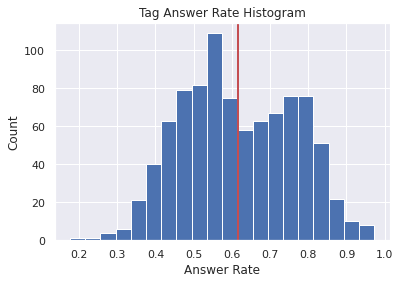

In [116]:
plt.title('Tag Answer Rate Histogram')
plt.xlabel('Answer Rate')
plt.ylabel('Count')
plt.hist(tag_groupby['answerCode'], bins=20)
plt.axvline(tag_groupby['answerCode'].mean(), color='r', linewidth=2)
plt.show()

In [135]:
sorted_tag = tag_groupby.sort_values('answerCode')['answerCode']
plot_tag = pd.concat([sorted_tag[:10], + sorted_tag[-10:]])

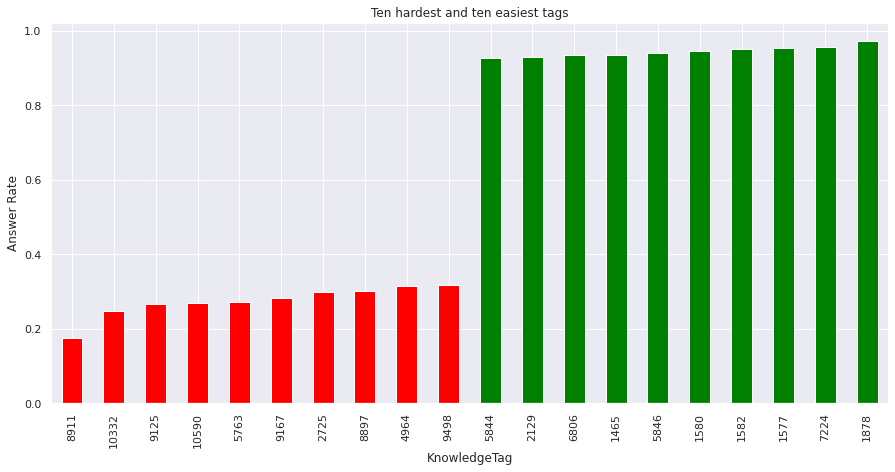

In [140]:
plt.figure(figsize=(15,7))
plt.title('Ten hardest and ten easiest tags')
plt.xlabel('Tag')
plt.ylabel('Answer Rate')
x = plot_tag.index
y = plot_tag.values
clrs = ['red' if y < 0.6 else 'green' for y in plot_tag.values]
plot_tag.plot.bar(x,y, color=clrs)
plt.show()

## 2. 문제를 많이 풀수록 정답률이 증가할까?

##### 유저별 푼 문제 수와 정답률 관계

Text(0, 0.5, 'Answer Rate')

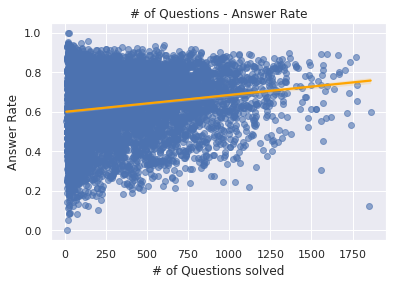

In [16]:
fig, ax = plt.subplots()
sns.regplot(data=stu_groupby, x='assessmentItemID', y='answerCode',
           line_kws={"color": "orange"}, scatter_kws={'alpha':0.6}, ax=ax)

ax.set_title('# of Questions - Answer Rate')
ax.set_xlabel('# of Questions solved')
ax.set_ylabel('Answer Rate')

##### 푼 문제 수와 정답률 관계

In [17]:
itemnum_ans = stu_groupby.groupby('assessmentItemID').mean()
itemnum_ans['num_items'] = itemnum_ans.index

Text(0, 0.5, 'Answer Rate')

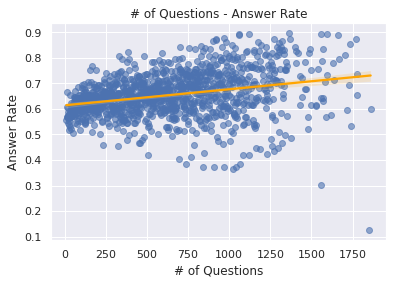

In [18]:
fig, ax = plt.subplots()
sns.regplot(data=itemnum_ans, x='num_items', y='answerCode',
           line_kws={"color": "orange"}, scatter_kws={'alpha':0.6}, ax=ax)

ax.set_title('# of Questions - Answer Rate')
ax.set_xlabel('# of Questions')
ax.set_ylabel('Answer Rate')

##### 푼 문제 수 평균을 기준으로 나뉜 두 분포 비교

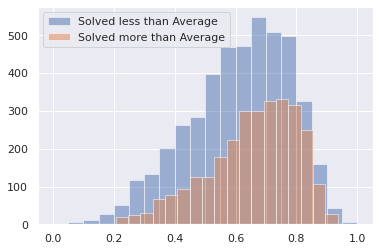

In [19]:
t = stu_groupby['assessmentItemID'].mean()
cond = stu_groupby['assessmentItemID'] >= t

plt.hist(stu_groupby[~cond].answerCode, alpha=0.5, bins=20, label='Solved less than Average')
plt.hist(stu_groupby[cond].answerCode, alpha=0.5,  bins=20, label='Solved more than Average')
plt.legend(loc='upper left')

plt.show()

##### 비슷한 문항 수를 푼 학생들의 평균과 정답률 관계

In [27]:
itemnum_ans = stu_groupby.groupby('assessmentItemID').mean()
bins = 300
itemnum_ans['bins'] = pd.cut(
    itemnum_ans.index,
    [i * (itemnum_ans.index.max() - itemnum_ans.index.min()) // bins for i in range(bins)]
)

In [28]:
itemnum_ans = itemnum_ans.groupby('bins').mean()
itemnum_ans['mid'] = list(map(lambda x: (x.left + x.right)//2, itemnum_ans.index))

Text(0, 0.5, 'Answer Rate')

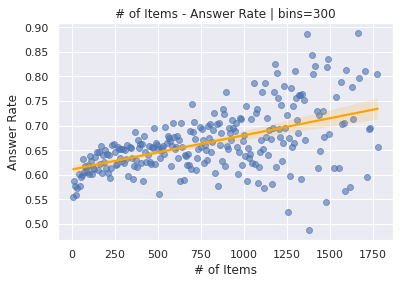

In [29]:
fig, ax = plt.subplots()
sns.regplot(data=itemnum_ans, x='mid', y='answerCode',
           line_kws={"color": "orange"}, scatter_kws={'alpha': 0.6}, ax=ax)

ax.set_title(f'# of Items - Answer Rate | bins={bins}')
ax.set_xlabel('# of Items')
ax.set_ylabel('Answer Rate')

##### 정답률이 중앙값 부근에 있는 10명 학생의 푼 문항 개수와 정답률

Text(0, 0.5, 'Answer Rate')

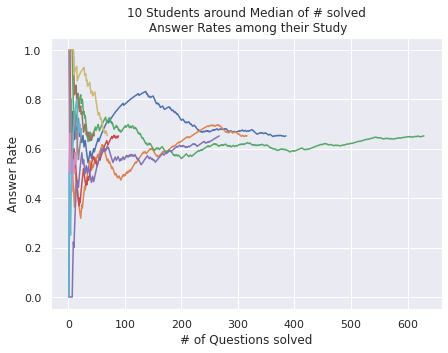

In [147]:
plt.figure(figsize=(7,5))
m = stu_groupby.answerCode.median(axis=0)
samples = np.argsort(np.abs(stu_groupby.answerCode - m))[:10]

for user_id in samples :
    item_seq = df[df.userID == user_id]
    num_corrects = np.cumsum(item_seq.answerCode.values)
    num_solved = np.arange(1,len(item_seq)+1)

    answer_rates = num_corrects / num_solved
    plt.plot(num_solved, answer_rates)

plt.title('10 Students around Median of # solved\n Answer Rates among their Study')
plt.xlabel('# of Questions solved')
plt.ylabel('Answer Rate')

##### 푼 문항의 개수가 중앙값 부근에 있는 10명 학생의 문항 개수와 정답률

Text(0, 0.5, 'Answer Rate')

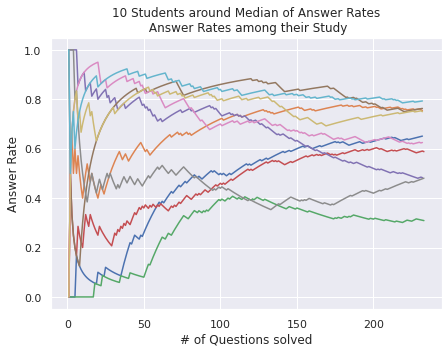

In [148]:
plt.figure(figsize=(7,5))
m = stu_groupby.assessmentItemID.median(axis=0)
samples = np.argsort(np.abs(stu_groupby.assessmentItemID - m))[:10]

for user_id in samples :
    item_seq = df[df.userID == user_id]
    num_corrects = np.cumsum(item_seq.answerCode.values)
    num_solved = np.arange(1,len(item_seq)+1)

    answer_rates = num_corrects / num_solved
    plt.plot(num_solved, answer_rates)

plt.title('10 Students around Median of Answer Rates\n Answer Rates among their Study')
plt.xlabel('# of Questions solved')
plt.ylabel('Answer Rate')

##### 푼 개수가 중앙값 부근인 10명의 학생들을 Window를 활용해 다시 그래프

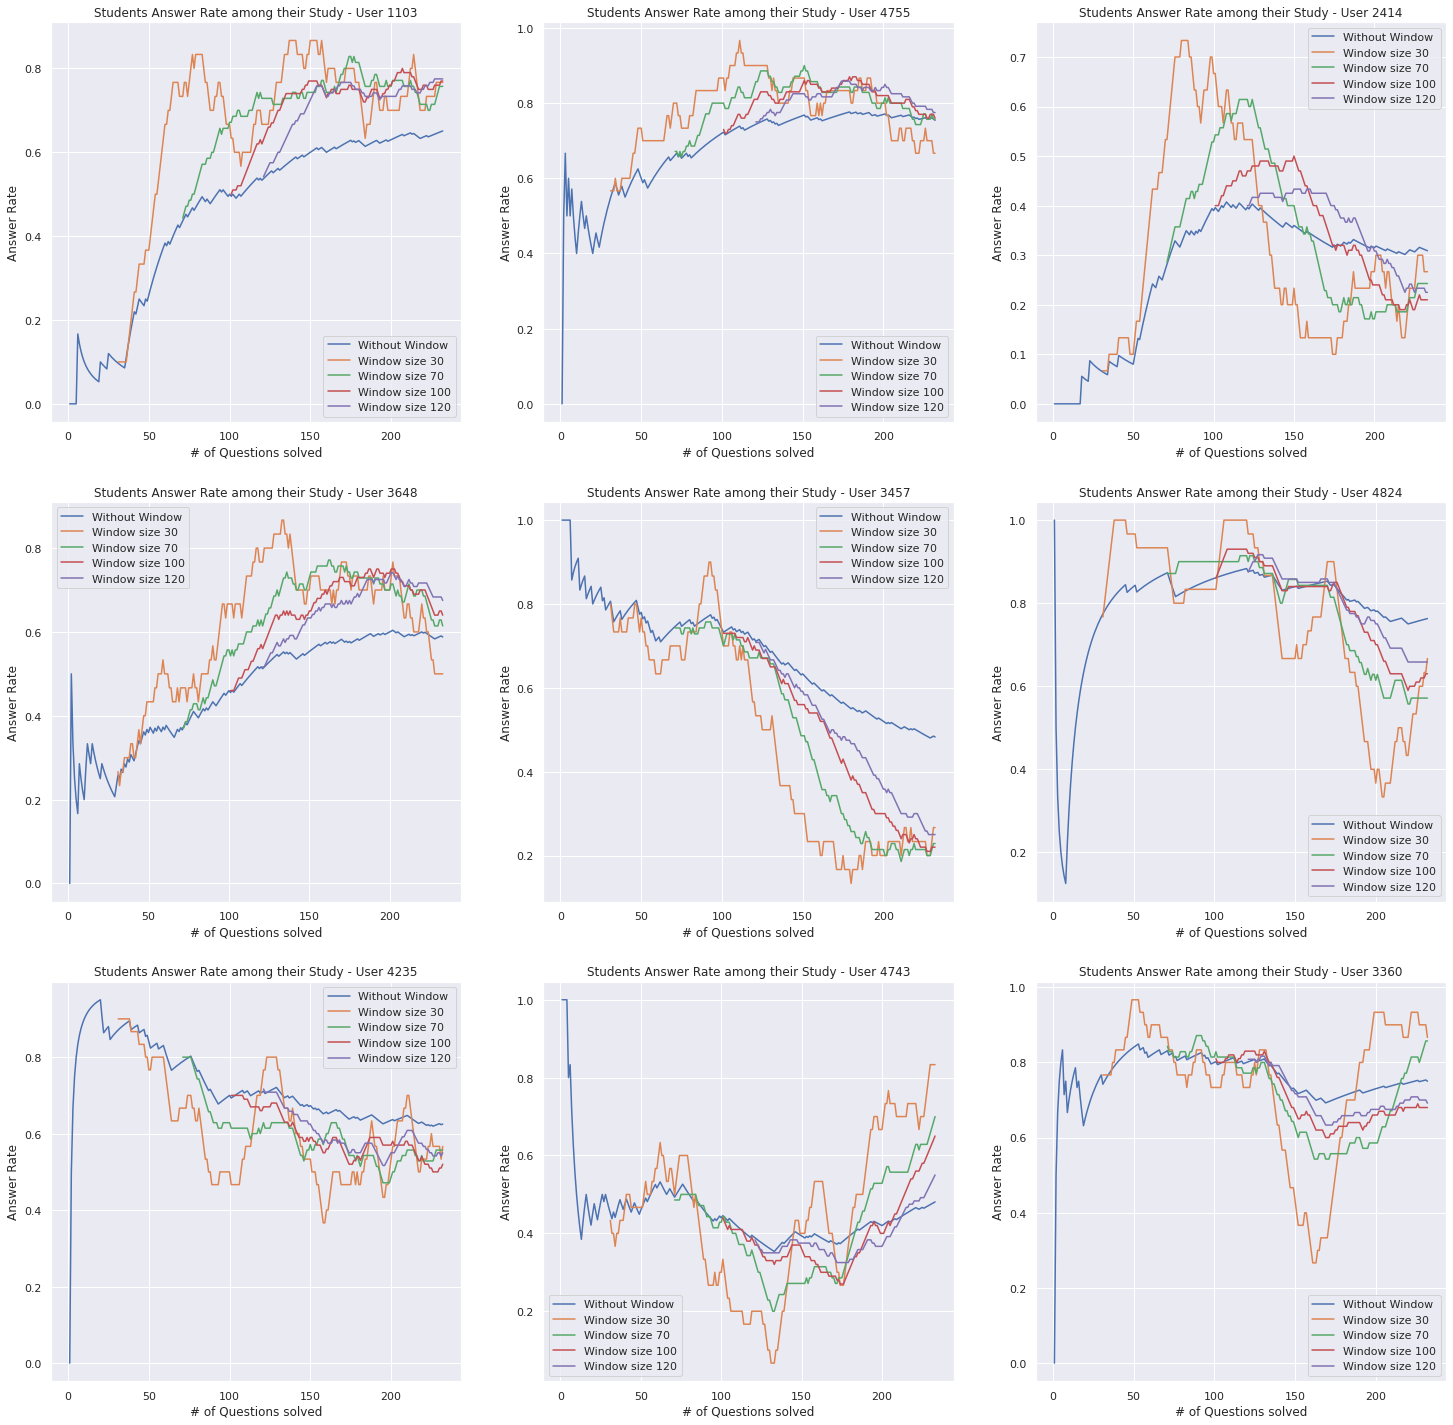

In [24]:
plt.figure(figsize=(25,25))
for i, user_id in enumerate(samples[:9]) :
    plt.subplot(3,3,i+1)

    item_seq = df[df.userID == user_id]
    num_corrects = np.cumsum(item_seq.answerCode.values)
    num_solved = np.arange(1,len(item_seq)+1)

    answer_rates = num_corrects / num_solved
    plt.plot(num_solved, answer_rates, label='Without Window')

    for window_size in [30,70,100,120]:
        window = num_corrects[window_size:] - num_corrects[:-window_size]
        answer_rates = window / window_size

        plt.plot(num_solved[window_size:], answer_rates, label=f'Window size {window_size}')

    plt.title(f'Students Answer Rate among their Study - User {user_id}')
    plt.xlabel('# of Questions solved')
    plt.ylabel('Answer Rate')
    plt.legend()

In [6]:
df['solvedNum'] = df.groupby('userID').assessmentItemID.cumcount()

In [ ]:
solvedNum = list()
for uid in tqdm(df.userID.unique()):
    item_dict = dict()
    item_list = df[df.userID == uid].assessmentItemID
    for iid in item_list:
        if iid not in item_dict.keys():
            item_dict[iid] = 1
        else :
            item_dict[iid] += 1
        solvedNum.append(item_dict[iid])
df['solvedNum'] = solvedNum

## 3. 더 많이 노출되면 정답률이 높은가?

##### 태그 노출 빈도와 정답률 관계

Text(0, 0.5, 'Answer Rate')

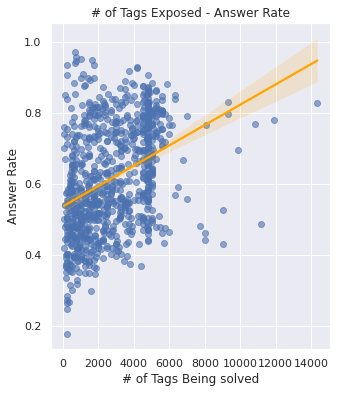

In [20]:
fig, ax = plt.subplots(figsize=(5,6))

sns.regplot(data=tag_groupby, x='assessmentItemID', y='answerCode',
           line_kws={"color": "orange"}, scatter_kws={'alpha':0.6}, ax=ax)

ax.set_title('# of Tags Exposed - Answer Rate')
ax.set_xlabel('# of Tags Being solved')
ax.set_ylabel('Answer Rate')

##### 태그 노출 빈도 평균을 기준으로 나뉜 두 분포 비교

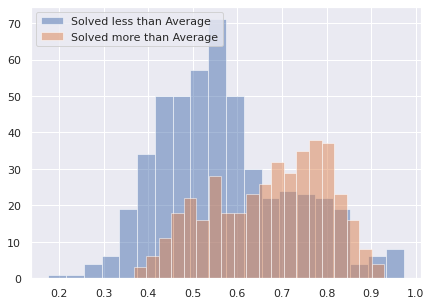

In [21]:
plt.figure(figsize=(7,5))
t = tag_groupby['assessmentItemID'].mean()
cond = tag_groupby['assessmentItemID'] >= t

plt.hist(tag_groupby[~cond].answerCode, alpha=0.5, bins=20, label='Solved less than Average')
plt.hist(tag_groupby[cond].answerCode, alpha=0.5,  bins=20, label='Solved more than Average')
plt.legend(loc='upper left')

plt.show()

##### 시험지 노출 빈도와 정답률

Text(0, 0.5, 'Answer Rate')

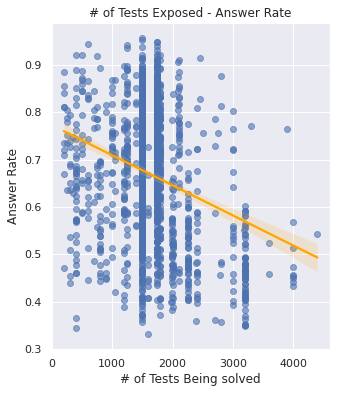

In [31]:
fig, ax = plt.subplots(figsize=(5,6))

sns.regplot(data=test_groupby, x='assessmentItemID', y='answerCode',
           line_kws={"color": "orange"}, scatter_kws={'alpha':0.6}, ax=ax)

ax.set_title('# of Tests Exposed - Answer Rate')
ax.set_xlabel('# of Tests Being solved')
ax.set_ylabel('Answer Rate')

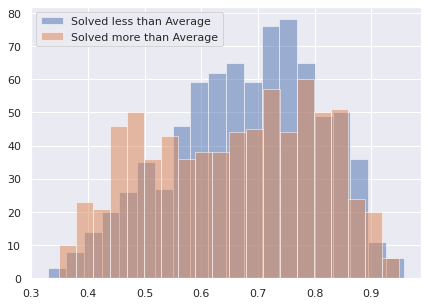

In [58]:
plt.figure(figsize=(7,5))
t = test_groupby['assessmentItemID'].mean()
cond = test_groupby['assessmentItemID'] >= t

plt.hist(test_groupby[~cond].answerCode, alpha=0.5, bins=20, label='Solved less than Average')
plt.hist(test_groupby[cond].answerCode, alpha=0.5,  bins=20, label='Solved more than Average')
plt.legend(loc='upper left')

plt.show()

## 6. 정답을 특별히 잘 맞추는 시간대가 있을까?

##### 시간대별 푼 문제 수

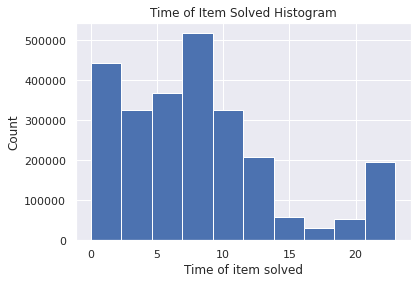

In [70]:
plt.title('Time of Item Solved Histogram')
plt.xlabel('Time of item solved')
plt.ylabel('Count')
plt.hist(df.Timestamp.dt.hour)
plt.show()

##### 시간대별 정답률

In [106]:
hour_df = df.groupby(df.Timestamp.dt.hour).agg({
    'answerCode': percentile
})

Text(0, 0.5, 'Answer Rate')

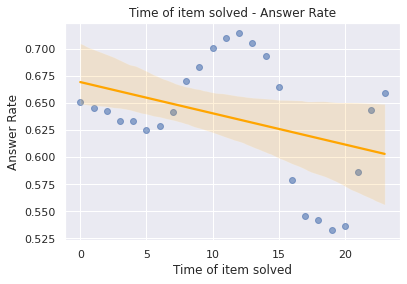

In [107]:
fig, ax = plt.subplots()
sns.regplot(data=hour_df, x=hour_df.index, y='answerCode',
           line_kws={"color": "orange"}, scatter_kws={'alpha':0.6}, ax=ax)

ax.set_title('Time of item solved - Answer Rate')
ax.set_xlabel('Time of item solved')
ax.set_ylabel('Answer Rate')

In [30]:
df['hour'] = df.Timestamp.dt.hour

## 7. 비슷한 내용을 연달아 풀면, 정답률이 오를까?

In [156]:
def most_freq(s):
    return np.bincount(s).argmax()

In [176]:
tag_solved = df.groupby(['KnowledgeTag']).agg({
    'userID' : most_freq,
    'assessmentItemID' : 'nunique'
})
tag_solved = tag_solved.nlargest(10, 'assessmentItemID')
tag_solved = tag_solved[['userID', 'assessmentItemID']]
tag_solved

,userID,assessmentItemID
KnowledgeTag,,
7597,54,41
2010,165,36
7600,54,34
8127,2493,33
1260,158,32
2085,53,31
5788,158,31
7621,504,31
8004,790,31


In [177]:
user_tag_df = df.groupby(['userID', 'KnowledgeTag'])

 62%|██████▏   | 304210/492307 [00:10<00:06, 29647.05it/s]


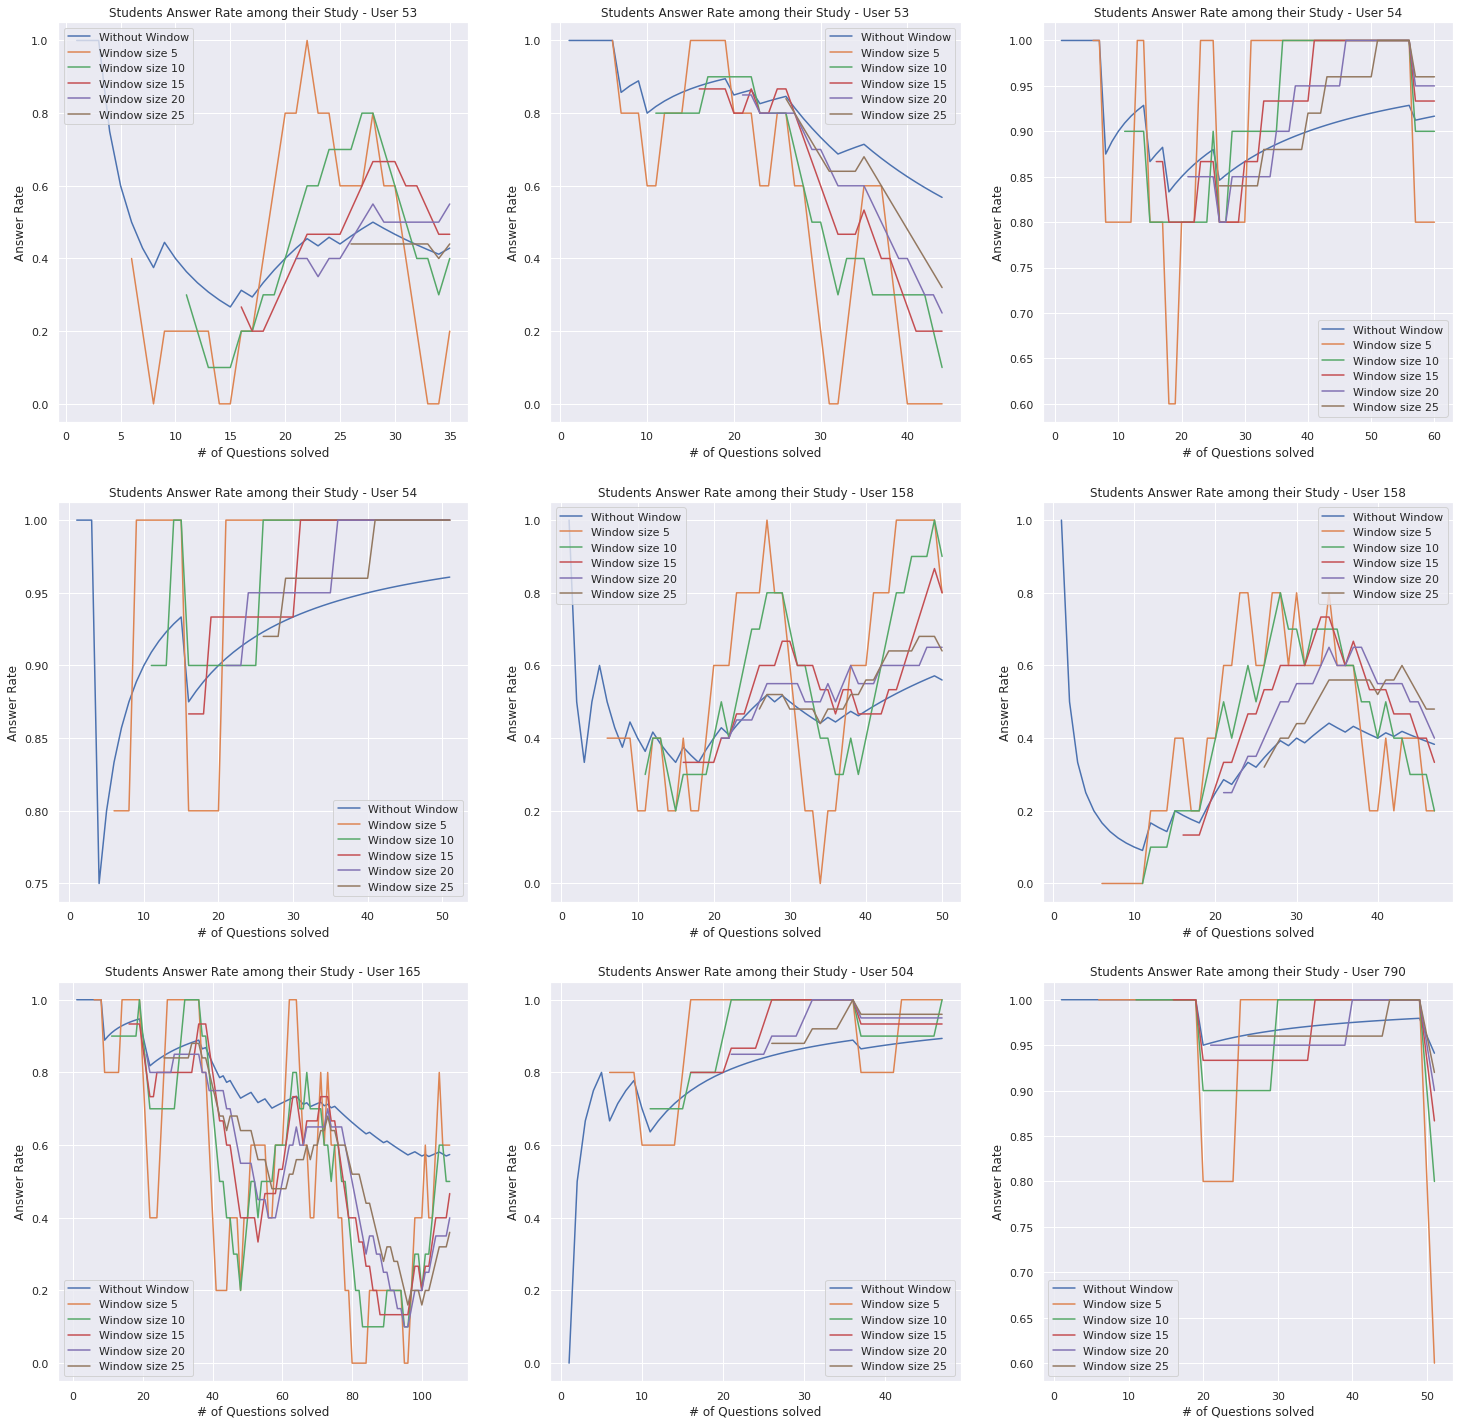

In [184]:
count = 0
plt.figure(figsize=(25,25))

for (user,tag), group_df in tqdm(user_tag_df):
    if tag not in tag_solved.index:
        continue
    if user != tag_solved.loc[tag].userID:
        continue
    if count >= 9:
        break
    else:
        count+=1
    plt.subplot(3,3,count)
    
    group_df = group_df.sort_values(by='Timestamp')

    num_corrects = np.cumsum(group_df.answerCode.values)
    num_solved = np.arange(1,len(group_df)+1)

    answer_rates = num_corrects / num_solved
    plt.plot(num_solved, answer_rates, label='Without Window')

    for window_size in [5,10,15,20,25]:
        window = num_corrects[window_size:] - num_corrects[:-window_size]
        answer_rates = window / window_size

        plt.plot(num_solved[window_size:], answer_rates, label=f'Window size {window_size}')

    plt.title(f'Students Answer Rate among their Study - User {user}')
    plt.xlabel('# of Questions solved')
    plt.ylabel('Answer Rate')
    plt.legend()
    

## 8. 하나의 test를 보면 모든 문제를 연달아 풀까?

##### Q. Test내 몇 문제만 골라풀 수 있을까?

##### A. 유저는 test를 보면 모든 문제를 푼다

In [22]:
user_test_df = train_df.groupby(['userID', 'testId']).agg({
    'assessmentItemID':'nunique',
}).reset_index()

test_df = train_df.groupby(['testId']).agg({
    'assessmentItemID':'nunique'
}).reset_index()

test_df.rename(columns={'assessmentItemID':'testItemNum'}, inplace=True)

temp_df = pd.merge(user_test_df, test_df, how='left', on='testId')
temp_df[temp_df['assessmentItemID'] != temp_df['testItemNum']]

,userID,testId,assessmentItemID,testItemNum


In [24]:
test_count = train_df.groupby(['userID', 'testId']).count().assessmentItemID
test_itemnum = train_df.groupby(['userID', 'testId']).nunique().assessmentItemID

(test_count % test_itemnum != 0).sum()

0

##### Q. 유저는 문제를 순서대로 풀까?

##### A. 문제 푸는 순서는 얼마든지 달라질수있다

##### A. Test 문제끼리 순서가 섞일수도있다

In [317]:
temp_df = df.sort_values(['userID', 'testId', 'Timestamp'])
solve_seq = temp_df.groupby(['userID', 'testId']).cumcount().values+1
item_seq = temp_df.assessmentItemID.apply(lambda x:int(x[-1])).values

In [351]:
temp_df[solve_seq != item_seq][3:11]

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag
77,0,A080008008,A080000008,0,2020-04-24 01:11:17,4658
78,0,A080008001,A080000008,1,2020-04-24 01:12:12,4673
79,0,A080008002,A080000008,1,2020-04-24 01:12:50,1444
80,0,A080008003,A080000008,1,2020-04-24 01:13:00,4661
81,0,A080008004,A080000008,0,2020-04-24 01:13:53,1443
82,0,A080008005,A080000008,1,2020-04-24 01:14:37,4660
83,0,A080008006,A080000008,0,2020-04-24 01:14:39,4661
84,0,A080008007,A080000008,0,2020-04-24 01:14:40,4658


In [352]:
solve_seq[solve_seq != item_seq][3:11]

array([1, 2, 3, 4, 5, 6, 7, 8])

##### Q. 한 시험을 여러번 푼 유저들이 있다 시험을 많이 풀수록 점수가 올라갈까?

##### A. 아니다 떨어지는 경우가 더 많다

In [17]:
# 문제를 몇번째 푸는지
solvedNum = list()
matchedNum = list()
for uid in tqdm(df.userID.unique()):
    item_dict = dict()
    match_dict = dict()
    user_df = df[df.userID == uid][['assessmentItemID', 'answerCode']]
    for iid, correct in user_df.values:
        if iid not in item_dict.keys():
            item_dict[iid] = 0
            match_dict[iid] = 0
        else :
            item_dict[iid] += 1
            
        solvedNum.append(item_dict[iid])
        matchedNum.append(match_dict[iid])
        if correct == 1: match_dict[iid] += 1
df['prevSolvedNum'] = solvedNum
df['prevMatchedNum'] = matchedNum

100%|██████████| 7442/7442 [00:18<00:00, 408.92it/s]


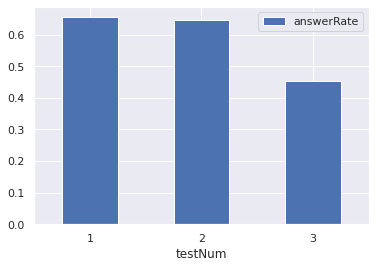

In [60]:
answerRates = df.groupby('solvedNum').answerCode.mean().values
bar_df = pd.DataFrame({'testNum':list(range(1,4)), 'answerRate':answerRates})
ax = bar_df.plot.bar(x='testNum', y='answerRate', rot=0)

## 9. 문제를 오래풀수록 정답률이 올라갈까?

In [10]:
elapsed_time = df.Timestamp.shift(-1) - df.Timestamp
elapsed_time = elapsed_time.values / np.timedelta64(1, 's')

time_cond1 = elapsed_time > 0
time_cond2 = elapsed_time < 900
elapsed_time[~(time_cond1 & time_cond2)] = elapsed_time[time_cond1 & time_cond2].mean()

df['elapsedTime'] = elapsed_time

elapsed_df = df.groupby('elapsedTime').agg({
    'answerCode':'mean'
})

Text(0, 0.5, 'Answer Rate')

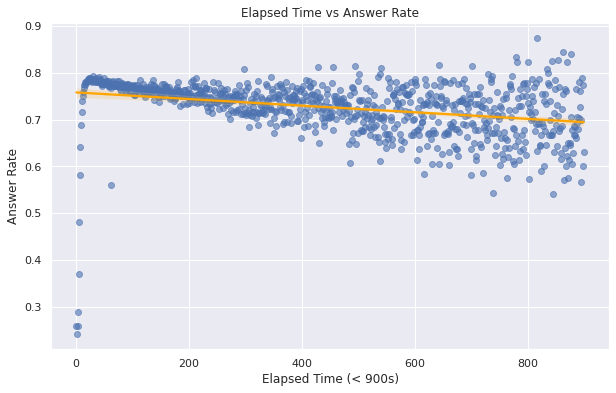

In [26]:
fig, ax = plt.subplots(figsize=(10,6))
sns.regplot(data=elapsed_df, x=elapsed_df.index, y='answerCode',
           line_kws={"color": "orange"}, scatter_kws={'alpha':0.6}, ax=ax)

ax.set_title('Elapsed Time vs Answer Rate')
ax.set_xlabel('Elapsed Time (< 900s)')
ax.set_ylabel('Answer Rate')